In [ ]:
%%time
import warnings
warnings.filterwarnings("ignore")
import shutil
import os
import pandas as pd
import matplotlib
# matplotlib.use(u'nbAgg')
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pickle
from sklearn.manifold import TSNE
from sklearn import preprocessing
import pandas as pd
from multiprocessing import Process# this is used for multithreading
import multiprocessing
import codecs# this is used for file operations 
import random as r

In [3]:
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import log_loss
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import re
from nltk.util import ngrams
from sklearn.feature_selection import SelectKBest, chi2, f_regression

import scipy.sparse
import gc
import pickle as pkl
from datetime import datetime as dt
import dask.dataframe as dd

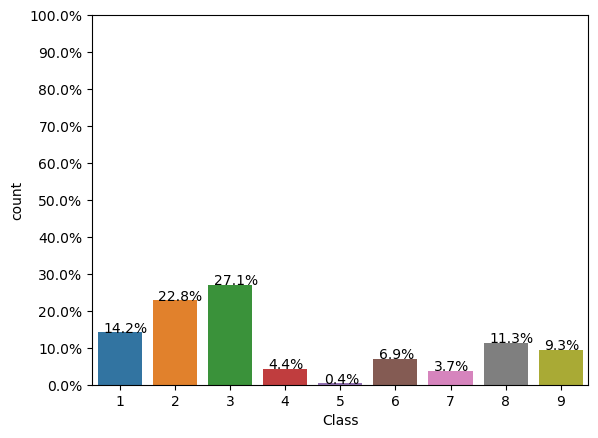

In [5]:
Y=pd.read_csv("trainLabels.csv")
total = len(Y)*1.
ax=sns.countplot(x="Class", data=Y)
for p in ax.patches:
        ax.annotate('{:.1f}%'.format(100*p.get_height()/total), (p.get_x()+0.1, p.get_height()+5))

#put 11 ticks (therefore 10 steps), from 0 to the total number of rows in the dataframe
ax.yaxis.set_ticks(np.linspace(0, total, 11))

#adjust the ticklabel to the desired format, without changing the position of the ticks. 
ax.set_yticklabels(map('{:.1f}%'.format, 100*ax.yaxis.get_majorticklocs()/total))
plt.show()

In [7]:
files=os.listdir('byteFiles')
filenames=Y['Id'].tolist()
class_y=Y['Class'].tolist()
class_bytes=[]
sizebytes=[]
fnames=[]
for file in files:
    statinfo=os.stat('byteFiles/'+file)
    file=file.split('.')[0]
    if any(file == filename for filename in filenames):
        i=filenames.index(file)
        class_bytes.append(class_y[i])
        sizebytes.append(statinfo.st_size/(1024.0*1024.0))
        fnames.append(file)
data_size_byte=pd.DataFrame({'ID':fnames,'size':sizebytes,'Class':class_bytes})
print (data_size_byte.head())

                     ID      size  Class
0  01azqd4InC7m9JpocGv5  4.234863      9
1  01IsoiSMh5gxyDYTl4CB  5.538818      2
2  01jsnpXSAlgw6aPeDxrU  3.887939      9
3  01kcPWA9K2BOxQeS5Rju  0.574219      1
4  01SuzwMJEIXsK7A8dQbl  0.370850      8


In [8]:
if not os.path.isdir("featurization"):
    os.makedirs("featurization")


if not os.path.isdir("featurization/featurization_final"):
    os.mkdir("featurization/featurization_final")


# Creating and writing to a file named "class_labels.pkl" to get class class_labels and ID from byte unigrams dataframe and save it for later use

class_labels=data_size_byte["Class"]

with open('featurization/class_labels.pkl', 'wb') as file:
    pkl.dump(class_labels, file)

with open('featurization/class_labels.pkl', 'rb') as file:
    class_labels=pkl.load(file)

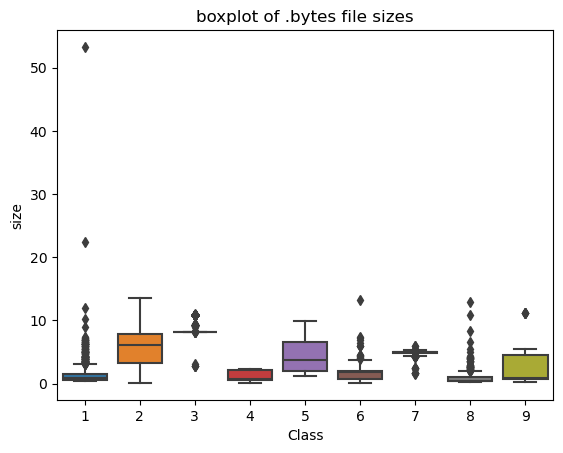

In [5]:
#boxplot of byte files
ax = sns.boxplot(x="Class", y="size", data=data_size_byte)
plt.title("boxplot of .bytes file sizes")
plt.show()

In [3]:
import os
files = os.listdir('byteFiles')
filenames=[]
array=[]
for file in files:
    if(file.endswith("bytes")):
        file=file.split('.')[0]
        text_file = open('byteFiles/'+file+".txt", 'w+')
        with open('byteFiles/'+file+".bytes","r") as fp:
            lines=""
            for line in fp:
                a=line.rstrip().split(" ")[1:]
                b=' '.join(a)
                b=b+"\n"
                text_file.write(b)
            fp.close()
            os.remove('byteFiles/'+file+".bytes")
        text_file.close()

In [6]:
files = os.listdir('byteFiles')
filenames2=[]
feature_matrix = np.zeros((len(files),257),dtype=int)
k=0

In [12]:
byte_feature_file=open('result.csv','w+')
byte_feature_file.write("ID,0,1,2,3,4,5,6,7,8,9,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??")

byte_feature_file.write("\n")

for file in files:
    filenames2.append(file)
    byte_feature_file.write(file+",")
    if(file.endswith("txt")):
        with open('byteFiles/'+file,"r") as byte_flie:
            for lines in byte_flie:
                line=lines.rstrip().split(" ")
                for hex_code in line:
                    if hex_code=='??':
                        feature_matrix[k][256]+=1
                    else:
                        feature_matrix[k][int(hex_code,16)]+=1
        byte_flie.close()
    for i, row in enumerate(feature_matrix[k]):
        if i!=len(feature_matrix[k])-1:
            byte_feature_file.write(str(row)+",")
        else:
            byte_feature_file.write(str(row))
    byte_feature_file.write("\n")
    
    k += 1

byte_feature_file.close()

In [9]:
uni_gram_byte_features = pd.read_csv("result.csv")

uni_gram_byte_features['ID']  = uni_gram_byte_features['ID'].str.split('.').str[0]

print('Unigram byte_featues shape ', uni_gram_byte_features.shape)

uni_gram_byte_features.head(2)

Unigram byte_featues shape  (10868, 258)


,ID,0,1,2,3,4,5,6,7,8,...,f7,f8,f9,fa,fb,fc,fd,fe,ff,??
0,01azqd4InC7m9JpocGv5,601905,3905,2816,3832,3345,3242,3650,3201,2965,...,2804,3687,3101,3211,3097,2758,3099,2759,5753,1824
1,01IsoiSMh5gxyDYTl4CB,39755,8337,7249,7186,8663,6844,8420,7589,9291,...,451,6536,439,281,302,7639,518,17001,54902,8588


In [6]:
def normalize(df):
    result1 = df.copy()
    for feature_name in df.columns:
        if (str(feature_name) != str('ID') and str(feature_name)!=str('Class')):
            max_value = df[feature_name].max()
            min_value = df[feature_name].min()
            result1[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
    return result1

In [12]:
uni_gram_byte_features__with_size = uni_gram_byte_features.merge(data_size_byte, on="ID")

uni_gram_byte_features__with_size.to_csv("featurization/uni_gram_byte_features__with_size.csv", index=False)

uni_gram_byte_features__with_size = normalize(uni_gram_byte_features__with_size)

In [7]:
from sklearn.feature_extraction.text import CountVectorizer

bigram_tokens="00,01,02,03,04,05,06,07,08,09,0a,0b,0c,0d,0e,0f,10,11,12,13,14,15,16,17,18,19,1a,1b,1c,1d,1e,1f,20,21,22,23,24,25,26,27,28,29,2a,\
2b,2c,2d,2e,2f,30,31,32,33,34,35,36,37,38,39,3a,3b,3c,3d,3e,3f,40,41,42,43,44,45,46,47,48,49,4a,4b,4c,4d,4e,4f,50,51,52,53,54,55,56,57,58,\
59,5a,5b,5c,5d,5e,5f,60,61,62,63,64,65,66,67,68,69,6a,6b,6c,6d,6e,6f,70,71,72,73,74,75,76,77,78,79,7a,7b,7c,7d,7e,7f,80,81,82,83,84,85,86,\
87,88,89,8a,8b,8c,8d,8e,8f,90,91,92,93,94,95,96,97,98,99,9a,9b,9c,9d,9e,9f,a0,a1,a2,a3,a4,a5,a6,a7,a8,a9,aa,ab,ac,ad,ae,af,b0,b1,b2,b3,b4,b5,\
b6,b7,b8,b9,ba,bb,bc,bd,be,bf,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,ca,cb,cc,cd,ce,cf,d0,d1,d2,d3,d4,d5,d6,d7,d8,d9,da,db,dc,dd,de,df,e0,e1,e2,e3,e4,\
e5,e6,e7,e8,e9,ea,eb,ec,ed,ee,ef,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,fa,fb,fc,fd,fe,ff,??"

bigram_tokens=bigram_tokens.split(",")

def calculate_bigram(bigram_tokens):
    sentence=""
    vocabulary_list_for_byte_bigrams=[]
    for i in tqdm(range(len(bigram_tokens))):
        for j in range(len(bigram_tokens)):
            bigram=bigram_tokens[i]+" "+bigram_tokens[j]
            sentence=sentence+bigram+","
            vocabulary_list_for_byte_bigrams.append(bigram)
    return vocabulary_list_for_byte_bigrams

vocabulary_list_for_byte_bigrams = calculate_bigram(bigram_tokens) 

100%|██████████| 257/257 [00:00<00:00, 483.57it/s] 


In [8]:
import scipy
vectorizer = CountVectorizer(tokenizer=lambda x: x.split(),lowercase=False, ngram_range=(2,2),vocabulary=vocabulary_list_for_byte_bigrams) 

file_list_byte_files=os.listdir( 'byteFiles')

features = ["ID"] + vectorizer.get_feature_names_out().tolist()

byte_file_bigram_df=pd.DataFrame(columns=features)

with open( "featurization/byte_files_bigram_df.csv", mode='w') as byte_file_bigram_df:
    byte_file_bigram_df.write(','.join(map(str, features)))
    byte_file_bigram_df.write('\n')
    for _, file in tqdm(enumerate(file_list_byte_files)):
        file_id=file.split(".")[0] #ID of each file
        file = open( 'byteFiles/' + file)
        corpus_byte_codes=[file.read().replace('\n', ' ').lower()] # corpus_byte_codes holds all the byte codes for a given file
        bigrams_counts = vectorizer.transform(corpus_byte_codes) # Returning a sparse vector containing all the bigram counts from the corpus_byte_codes
         
        # Update each row of our dataframe with the bigram counts of the respective file
        row = scipy.sparse.csr_matrix(bigrams_counts).toarray() 
        
        # Write a single row in the CSV file
        byte_file_bigram_df.write(','.join(map(str, [file_id]+list(row[0]))))
        
        byte_file_bigram_df.write('\n')
        
        file.close()

10868it [3:08:58,  1.04s/it]


In [ ]:
%%time
X_byte_bigram_all_df = pd.read_csv("featurization/byte_files_bigram_df.csv", nrows=1000)  # Example: Read first 1000 rows
X_byte_bigram_all_df.head(2) 

In [11]:
X_byte_bigram_all_df.sample(10)

,ID,00 00,00 01,00 02,00 03,00 04,00 05,00 06,00 07,00 08,...,?? f7,?? f8,?? f9,?? fa,?? fb,?? fc,?? fd,?? fe,?? ff,?? ??
648,1XKY6TxM2eICFymS4AsN,21750,728,68,42,186,23,7,22,41,...,0,0,0,0,0,0,0,0,0,11562
750,2CG9IWLp3BJcZNDVtFio,11640,176,95,81,74,52,20,48,793,...,0,0,0,0,0,0,0,0,0,19438
733,2amRyMxPKTXJwibdWHu8,5653,34,29,63,19,54,19,39,19,...,0,0,0,0,0,0,0,0,0,1491092
416,1cdtwSyhmiekLoH7OUEs,2219,48,24,35,20,20,15,11,26,...,0,0,0,0,0,0,0,0,0,17281
825,2ipXFC47Umax9kQfgcTe,15342,193,263,154,150,10,6,4,159,...,0,0,0,0,0,0,0,0,0,4789
161,0J2pOclDKjadkL57eroz,2830,18,10,15,15,11,13,12,13,...,0,0,0,0,0,0,0,0,0,1550486
807,2HAvl4QhqKBGu8cWedtY,107782,797,623,549,771,694,688,503,699,...,0,0,0,0,0,0,0,0,0,451
654,1YAFzJjOeKUCc7pubM9q,48108,261,179,221,172,150,134,115,159,...,0,0,0,0,0,0,0,0,0,414076
160,0iZTHuQ5KMb4RtAlrz6D,12489,119,19,37,36,10,13,29,12,...,0,0,0,0,0,0,0,0,0,198
296,0W1RChtwZvj4Qy78GYUJ,2232,10,4,9,9,188,13,3,4,...,0,0,0,0,0,0,0,0,0,10781


In [13]:
X_byte_bigram_all_df.shape

(1000, 66050)

In [ ]:
import pickle
with open('featurization/class_labels.pkl', 'rb') as file:
    class_labels=pickle.load(file)

In [ ]:
import pandas as pd
from sklearn.feature_selection import SelectKBest, chi2

# Assuming X_byte_bigram_all_df contains the file path to your CSV file
csv_file_path = "featurization/byte_files_bigram_df.csv"

chunk_size = 1000
result_df = pd.DataFrame(X_byte_bigram_all_df.columns)

# Initialize start and end index for slicing

chunk_size = 1000
num_rows = 10869
start_index = 0
end_index = min(start_index + chunk_size, num_rows)

while start_index < num_rows:
    chunk_df = pd.read_csv(csv_file_path, skiprows=range(1, start_index), nrows=chunk_size)
    end_index= min(end_index,num_rows)
    chunk_df = chunk_df.fillna(0)
    chunk_labels = class_labels[start_index:end_index]
    select_kbest_object = SelectKBest(score_func=chi2, k=2000)
    most_imp_features_chunk = select_kbest_object.fit(chunk_df.drop("ID", axis=1),chunk_labels )
    most_imp_chunk_feature_score_df = pd.DataFrame(most_imp_features_chunk.scores_)
    most_imp_chunk_columns_df = pd.DataFrame(chunk_df.drop("ID", axis=1).columns)
    chunk_feature_score_df = pd.concat([most_imp_chunk_columns_df, most_imp_chunk_feature_score_df], axis=1)
    chunk_feature_score_df.columns = ["Byte Bigram Top 2000 Feature Names", "Byte Bigram Top 2000 Feature Score"]
    
    result_df = pd.concat([result_df, chunk_feature_score_df.nlargest(10, "Byte Bigram Top 2000 Feature Score")])
    
    start_index = end_index
    end_index = min(start_index + chunk_size, num_rows)

    # Ensure end_index does not exceed num_rows
    end_index = min(end_index, num_rows)
result_df = result_df.fillna(0)

print(result_df.shape)
print(result_df.head(2))


In [19]:
result_df.shape

(66150, 3)